In [1]:
import io
import tarfile
from pathlib import Path

import numpy as np

from ugradiolab.data.schema import CaptureRecord

DATA_SRC = 'data/lab2_cold_cal.tar.gz'  # directory of .npz or .tar.gz archive


def _resolve_source(source):
    src = Path(source).expanduser()
    if src.exists():
        return src

    # Try resolving relative to cwd and all parent directories.
    cwd = Path.cwd().resolve()
    for base in (cwd, *cwd.parents):
        candidate = (base / source).resolve()
        if candidate.exists():
            return candidate

    raise FileNotFoundError(
        f'Could not find {source!r}. cwd={cwd}. '
        'Tried cwd and all parent directories.'
    )


def _prefix_from_name(name):
    # filename convention: {prefix}_{cal|obs}_{YYYYMMDD}_{HHMMSS}.npz
    return Path(name).name.rsplit('_', 3)[0]


def _parse_dbm(prefix, stem):
    if not prefix.startswith(stem):
        return None
    try:
        return int(prefix.replace(stem, ''))
    except ValueError:
        return None


def load_dataset(source):
    src = _resolve_source(source)
    data = {}

    if src.is_dir():
        files = sorted(src.glob('*.npz'))
        for f in files:
            data[_prefix_from_name(f.name)] = CaptureRecord.load(f)
    elif src.is_file() and src.suffixes[-2:] == ['.tar', '.gz']:
        with tarfile.open(src, 'r:gz') as tar:
            members = sorted(
                [m for m in tar.getmembers() if m.isfile() and m.name.endswith('.npz')],
                key=lambda m: m.name,
            )
            for m in members:
                extracted = tar.extractfile(m)
                if extracted is None:
                    continue
                data[_prefix_from_name(m.name)] = CaptureRecord.load(
                    io.BytesIO(extracted.read())
                )
    else:
        raise FileNotFoundError(
            f'Expected a directory of .npz files or a .tar.gz archive, got: {src}'
        )

    if not data:
        raise RuntimeError(f'No .npz files found in: {src}')

    return data, src


# Load every .npz into a dict keyed by prefix (e.g. COLD-TONE--35, COLD-BASE-PRE)
data, resolved_src = load_dataset(DATA_SRC)

# Discover available paired calibration levels from what is actually present.
tone_dbm = sorted(
    d for d in (_parse_dbm(prefix, 'COLD-TONE-') for prefix in data) if d is not None
)
base_dbm = sorted(
    d for d in (_parse_dbm(prefix, 'COLD-BASE-') for prefix in data) if d is not None
)
paired_dbm = sorted(set(tone_dbm).intersection(base_dbm))

if not paired_dbm:
    raise RuntimeError('No paired COLD-TONE-<dBm> and COLD-BASE-<dBm> captures found.')

print(f'Loaded {len(data)} files from {resolved_src}')
print(f'Paired dBm levels: {paired_dbm}')
for key in sorted(data):
    kind = 'cal' if data[key].siggen_freq is not None else 'obs'
    print(f'  {key:20s} ({kind})')


/home/ikaros/projects/ay-121/.venv/lib/python3.12/site-packages/rtlsdr/__init__.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Loaded 34 files from /home/ikaros/projects/ay-121/data/lab2_cold_cal.tar.gz
Paired dBm levels: [-90, -86, -82, -78, -74, -70, -66, -62, -58, -54, -50, -46, -42, -38, -34, -30]
  COLD-BASE--30        (obs)
  COLD-BASE--34        (obs)
  COLD-BASE--38        (obs)
  COLD-BASE--42        (obs)
  COLD-BASE--46        (obs)
  COLD-BASE--50        (obs)
  COLD-BASE--54        (obs)
  COLD-BASE--58        (obs)
  COLD-BASE--62        (obs)
  COLD-BASE--66        (obs)
  COLD-BASE--70        (obs)
  COLD-BASE--74        (obs)
  COLD-BASE--78        (obs)
  COLD-BASE--82        (obs)
  COLD-BASE--86        (obs)
  COLD-BASE--90        (obs)
  COLD-BASE-POST       (obs)
  COLD-BASE-PRE        (obs)
  COLD-TONE--30        (cal)
  COLD-TONE--34        (cal)
  COLD-TONE--38        (cal)
  COLD-TONE--42        (cal)
  COLD-TONE--46        (cal)
  COLD-TONE--50        (cal)
  COLD-TONE--54        (cal)
  COLD-TONE--58        (cal)
  COLD-TONE--62        (cal)
  COLD-TONE--66        (cal)
  COLD-TONE-

In [2]:
import pandas as pd


def to_complex(raw):
    """Convert (nblocks, nsamples, 2) int8 I/Q to (nblocks, nsamples) complex128."""
    return raw[..., 0].astype(np.float64) + 1j * raw[..., 1].astype(np.float64)


rows = []
for prefix, rec in data.items():
    is_cal = rec.siggen_freq is not None
    rows.append({
        'prefix': prefix,
        'type': 'cal' if is_cal else 'obs',
        'samples': to_complex(rec.data),
        'sample_rate': rec.sample_rate,
        'center_freq': rec.center_freq,
        'gain': rec.gain,
        'direct': rec.direct,
        'unix_time': rec.unix_time,
        'jd': rec.jd,
        'lst': rec.lst,
        'alt': rec.alt,
        'az': rec.az,
        'siggen_freq': rec.siggen_freq if is_cal else np.nan,
        'siggen_amp': rec.siggen_amp if is_cal else np.nan,
        'siggen_rf_on': rec.siggen_rf_on if is_cal else False,
    })

if not rows:
    raise RuntimeError('No captures loaded into rows; check DATA_SRC and load_dataset().')

if 'unix_time' not in rows[0]:
    raise KeyError('unix_time is missing in loaded capture metadata.')

df = pd.DataFrame(rows).sort_values('unix_time').reset_index(drop=True)
df


prefix type                                            samples  \
0    COLD-BASE-PRE  obs  [[-1j, (-1-1j), 0j, (-1+0j), (-1+0j), -1j, -1j...   
1    COLD-TONE--90  cal  [[(-1-1j), (-1+0j), (-1-1j), -1j, -1j, (-1-1j)...   
2    COLD-BASE--90  obs  [[0j, (-1-1j), (-1-1j), (-1+0j), (-1-1j), -1j,...   
3    COLD-TONE--86  cal  [[-1j, (-1-1j), -1j, (-1+0j), 0j, (-1-1j), (-1...   
4    COLD-BASE--86  obs  [[(-1+0j), (-1-1j), (-1-1j), 0j, -1j, (-1+0j),...   
5    COLD-TONE--82  cal  [[(-1-1j), (-1-1j), -1j, 0j, -1j, -1j, (-1-1j)...   
6    COLD-BASE--82  obs  [[-1j, (-1+0j), (-1+0j), (-1+0j), (-1-1j), -1j...   
7    COLD-TONE--78  cal  [[(-1-1j), (-1-1j), (-1-1j), (-1-1j), 0j, (-1-...   
8    COLD-BASE--78  obs  [[-1j, (-1+0j), (-1+0j), (-1+0j), (-1-1j), -1j...   
9    COLD-TONE--74  cal  [[-1j, (-1-1j), (-1-1j), 0j, (-1+0j), (-1-1j),...   
10   COLD-BASE--74  obs  [[(-1-1j), -1j, -1j, -1j, (-1-1j), (-1-1j), (-...   
11   COLD-TONE--70  cal  [[(-1+0j), -1j, (-1-1j), (-1-1j), (-1-1j), (-1...   
12   COLD-BASE--70  obs  [[(-1-1j), (-1+0j), -1j, (-1+0j), 0j, -1j, (-1...   
13   COLD-TONE--66  cal  [[(-1-1j), 0j, 0j, (-1+0j), (-1+0j), -1j, (-1-...   
14   COLD-BASE--66  obs  [[(-1-1j), 0j, (-1-1j), 0j, 0j, (-2-1j), (-1-1...   
15   COLD-TONE--62  cal  [[0j, (-1+0j), 0j, (-1+0j), (-1+0j), (-1-1j), ...   
16   COLD-BASE--62  obs  [[0j, (-1+0j), (-1+0j), (-1+0j), (-1-1j), (-1-...   
17   COLD-TONE--58  cal  [[(-1-1j), -1j, (-1+0j), (-1+0j), -1j, (-1-1j)...   
18   COLD-BASE--58  obs  [[0j, -1j, (-1-1j), (-1-1j), (-1-1j), (-1-1j),...   
19   COLD-TONE--54  cal  [[(-1+0j), 0j, (-1-1j), -1j, -1j, -1j, (-1-1j)...   
20   COLD-BASE--54  obs  [[(-1-1j), -1j, (-1-1j), (-1+0j), (-1+0j), -1j...   
21   COLD-TONE--50  cal  [[(-1-1j), (-1-1j), (-1-1j), (-1+0j), (-1+0j),...   
22   COLD-BASE--50  obs  [[(-1-1j), (-1+0j), (-1+0j), -1j, -1j, (-1-1j)...   
23   COLD-TONE--46  cal  [[(-1-1j), (-1+0j), (-1-1j), (-1-1j), (-1+0j),...   
24   COLD-BASE--46  obs  [[(-1-1j), -1j, (-1-1j), (-1-1j), 0j, (-1-1j),...   
25   COLD-TONE--42  cal  [[(-1-1j), -1j, (-1-1j), (-1+0j), -1j, -1j, (-...   
26   COLD-BASE--42  obs  [[(-1-1j), -1j, (-1-1j), (-1-1j), (-1-1j), (-1...   
27   COLD-TONE--38  cal  [[(-1+0j), (-1-1j), -1j, (-1-1j), (-1-1j), (-1...   
28   COLD-BASE--38  obs  [[(-1-1j), (-1-1j), (-1-1j), (-1-1j), -1j, 0j,...   
29   COLD-TONE--34  cal  [[0j, -1j, -1j, 0j, (-1+0j), -1j, -1j, (-1+0j)...   
30   COLD-BASE--34  obs  [[-1j, -1j, -1j, (-1+0j), (-1-1j), (-1+0j), (-...   
31   COLD-TONE--30  cal  [[(-1-1j), (-1+0j), (-1-1j), (-1-1j), -1j, -1j...   
32   COLD-BASE--30  obs  [[(-1-1j), (-1+0j), (-1-1j), (-1+0j), 0j, (-1-...   
33  COLD-BASE-POST  obs  [[(-1+0j), (-1-1j), -1j, -1j, 0j, -1j, -1j, (-...   

    sample_rate   center_freq  gain  direct     unix_time            jd  \
0     2560000.0  1.420000e+09   0.0   False  1.771384e+09  2.461090e+06   
1     2560000.0  1.420000e+09   0.0   False  1.771384e+09  2.461090e+06   
2     2560000.0  1.420000e+09   0.0   False  1.771384e+09  2.461090e+06   
3     2560000.0  1.420000e+09   0.0   False  1.771384e+09  2.461090e+06   
4     2560000.0  1.420000e+09   0.0   False  1.771384e+09  2.461090e+06   
5     2560000.0  1.420000e+09   0.0   False  1.771384e+09  2.461090e+06   
6     2560000.0  1.420000e+09   0.0   False  1.771384e+09  2.461090e+06   
7     2560000.0  1.420000e+09   0.0   False  1.771384e+09  2.461090e+06   
8     2560000.0  1.420000e+09   0.0   False  1.771384e+09  2.461090e+06   
9     2560000.0  1.420000e+09   0.0   False  1.771384e+09  2.461090e+06   
10    2560000.0  1.420000e+09   0.0   False  1.771384e+09  2.461090e+06   
11    2560000.0  1.420000e+09   0.0   False  1.771384e+09  2.461090e+06   
12    2560000.0  1.420000e+09   0.0   False  1.771384e+09  2.461090e+06   
13    2560000.0  1.420000e+09   0.0   False  1.771384e+09  2.461090e+06   
14    2560000.0  1.420000e+09   0.0   False  1.771384e+09  2.461090e+06   
15    2560000.0  1.420000e+09   0.0   False  1.771384e+09  2.461090e+06   
16    

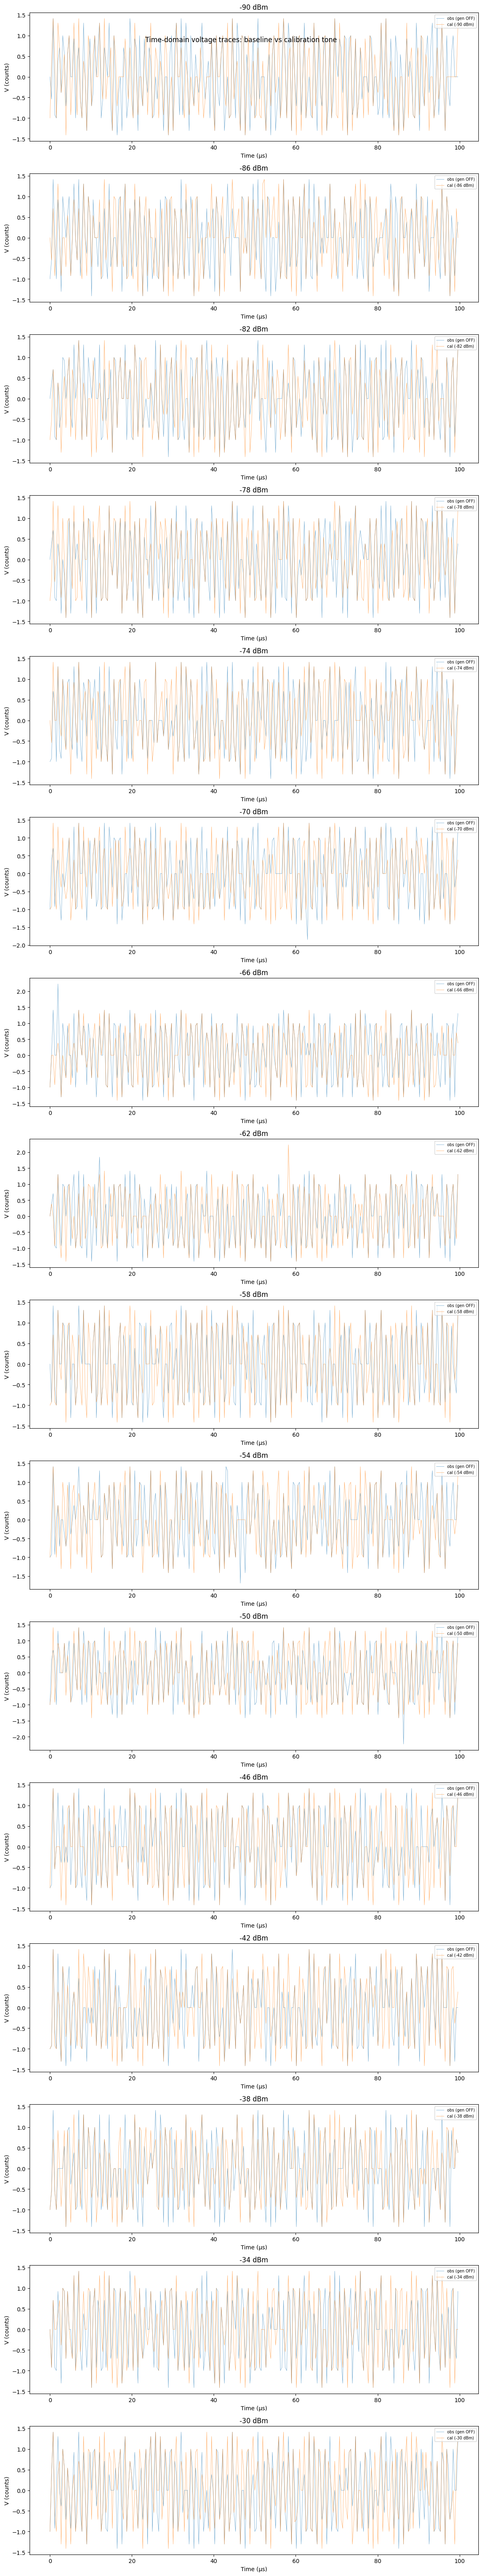

In [3]:
import matplotlib.pyplot as plt

sample_rate = 2.56e6
center_freq = 1.42e9
nshow = 256  # samples to plot (first block only)

t_us = np.arange(nshow) / sample_rate * 1e6  # time axis in microseconds

fig, axes = plt.subplots(len(paired_dbm), 1, figsize=(12, 4 * len(paired_dbm)))
axes = np.atleast_1d(axes)

for i, dbm in enumerate(paired_dbm):
    ax = axes[i]
    tone_key = f'COLD-TONE-{dbm}'
    base_key = f'COLD-BASE-{dbm}'

    cal_iq = df.loc[df['prefix'] == tone_key, 'samples'].values[0]
    obs_iq = df.loc[df['prefix'] == base_key, 'samples'].values[0]

    # Reconstruct RF: V(t) = I(t)cos(2π f_c t) - Q(t)sin(2π f_c t)
    t_s = np.arange(nshow) / sample_rate
    carrier_cos = np.cos(2 * np.pi * center_freq * t_s)
    carrier_sin = np.sin(2 * np.pi * center_freq * t_s)

    cal_rf = cal_iq[0, :nshow].real * carrier_cos - cal_iq[0, :nshow].imag * carrier_sin
    obs_rf = obs_iq[0, :nshow].real * carrier_cos - obs_iq[0, :nshow].imag * carrier_sin

    ax.plot(t_us, obs_rf, alpha=0.7, lw=0.5, label='obs (gen OFF)')
    ax.plot(t_us, cal_rf, alpha=0.7, lw=0.5, label=f'cal ({dbm} dBm)')
    ax.set_ylabel('V (counts)')
    ax.set_xlabel('Time (μs)')
    ax.set_title(f'{dbm} dBm')
    ax.legend(loc='upper right', fontsize=7)

fig.suptitle('Time-domain voltage traces: baseline vs calibration tone')
plt.tight_layout()
plt.show()



In [4]:
def power_spectrum(iq, sample_rate, center_freq):
    """Compute mean power spectrum from complex I/Q data.

    Parameters
    ----------
    iq : (nblocks, nsamples) complex array
    sample_rate, center_freq : float

    Returns
    -------
    freqs_mhz : frequency axis in MHz (DC bin omitted)
    psd : mean |FFT|^2 averaged over blocks (DC bin omitted)
    """
    nblocks, nsamples = iq.shape
    # Complex FFT + shift so DC is centered
    fft_data = np.fft.fftshift(np.fft.fft(iq, axis=1), axes=1)
    psd = np.mean(np.abs(fft_data)**2, axis=0)
    freqs = np.fft.fftshift(np.fft.fftfreq(nsamples, d=1.0/sample_rate))
    freqs_mhz = (freqs + center_freq) / 1e6
    # Omit DC bin (LO leakage)
    dc = nsamples // 2
    mask = np.ones(nsamples, dtype=bool)
    mask[dc] = False
    return freqs_mhz[mask], psd[mask]

# Compute power spectra for all 44 captures
sample_rate = df['sample_rate'].iloc[0]
center_freq = df['center_freq'].iloc[0]

df['freqs_mhz'] = None
df['psd'] = None
for idx, row in df.iterrows():
    freqs_mhz, psd = power_spectrum(row['samples'], sample_rate, center_freq)
    df.at[idx, 'freqs_mhz'] = freqs_mhz
    df.at[idx, 'psd'] = psd

print(f'Computed power spectra for {len(df)} captures')
print(f'Frequency range: {freqs_mhz[0]:.3f} – {freqs_mhz[-1]:.3f} MHz')
print(f'Frequency bins: {len(freqs_mhz)}')

Computed power spectra for 34 captures
Frequency range: 1418.720 – 1421.280 MHz
Frequency bins: 32767


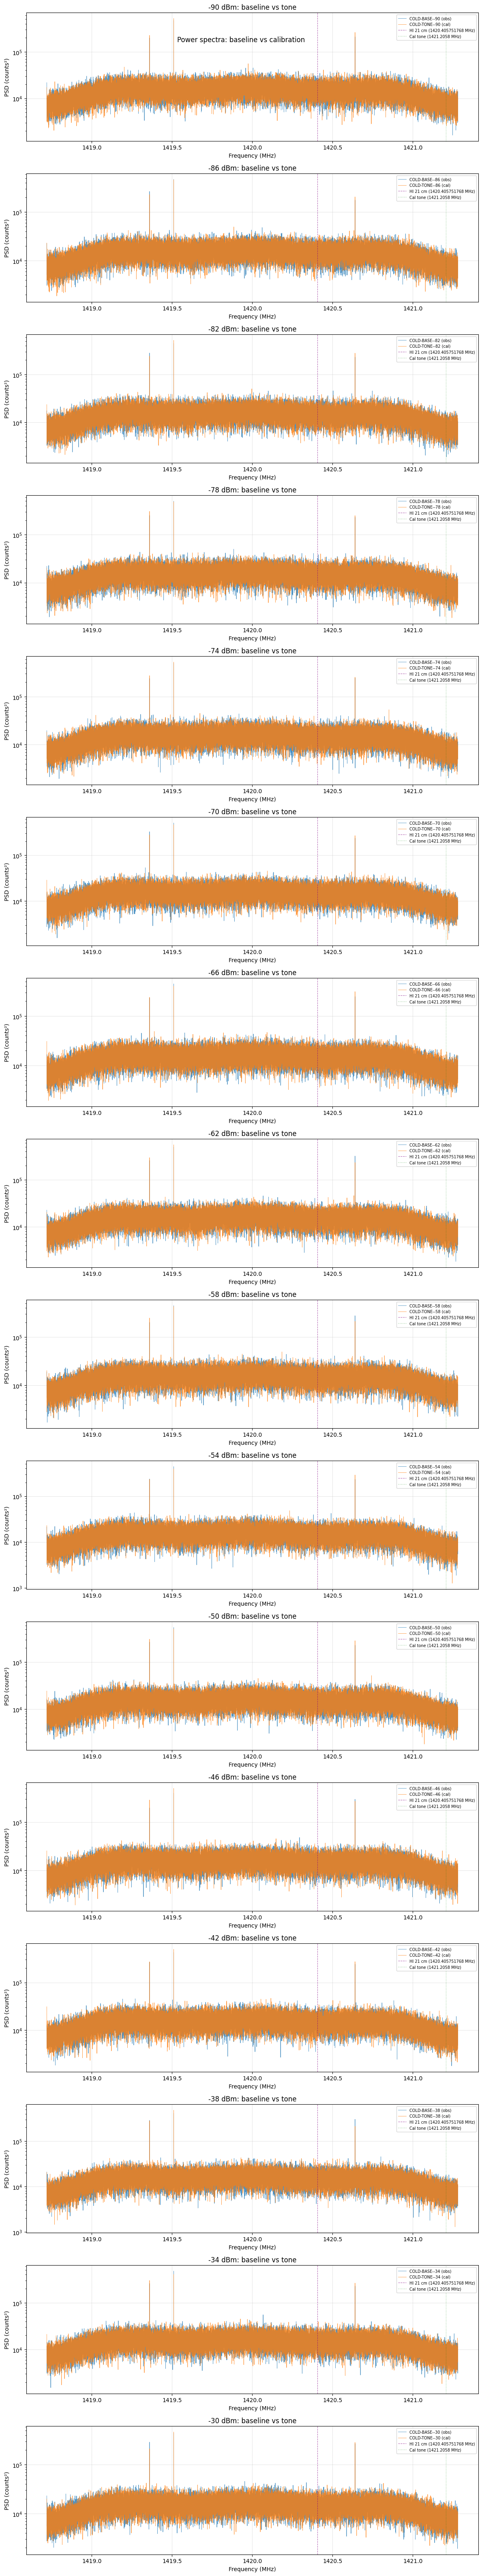

In [5]:
# Power spectrum plots for each available paired dBm level
HI_FREQ = 1420.405751768  # 21-cm hydrogen line (MHz)
CAL_TONE_MHZ = 1421.2058  # calibration tone frequency

plot_pairs = []
for dbm in paired_dbm:
    plot_pairs.append((f'COLD-BASE-{dbm}', f'COLD-TONE-{dbm}', f'{dbm} dBm: baseline vs tone'))

fig, axes = plt.subplots(len(plot_pairs), 1, figsize=(12, 4 * len(plot_pairs)))
axes = np.atleast_1d(axes)

for i, (obs_key, cal_key, title) in enumerate(plot_pairs):
    ax = axes[i]
    obs_row = df.loc[df['prefix'] == obs_key].iloc[0]
    cal_row = df.loc[df['prefix'] == cal_key].iloc[0]

    ax.semilogy(obs_row['freqs_mhz'], obs_row['psd'], lw=0.6, alpha=0.8, label=f'{obs_key} (obs)')
    ax.semilogy(cal_row['freqs_mhz'], cal_row['psd'], lw=0.6, alpha=0.8, label=f'{cal_key} (cal)')
    ax.axvline(HI_FREQ, color='purple', alpha=0.6, lw=0.8, ls='--', label=f'HI 21 cm ({HI_FREQ} MHz)')
    ax.axvline(CAL_TONE_MHZ, color='green', alpha=0.4, lw=1, ls=':',
               label=f'Cal tone ({CAL_TONE_MHZ} MHz)')
    ax.set_ylabel('PSD (counts²)')
    ax.set_xlabel('Frequency (MHz)')
    ax.set_title(title)
    ax.legend(loc='upper right', fontsize=7)
    ax.grid(True, alpha=0.3)

fig.suptitle('Power spectra: baseline vs calibration')
plt.tight_layout()
plt.show()



In [6]:
# Summary statistics DataFrame
tone_freq_mhz = 1421.2058

stats_rows = []
for dbm in paired_dbm:
    tone_row = df.loc[df['prefix'] == f'COLD-TONE-{dbm}'].iloc[0]
    base_row = df.loc[df['prefix'] == f'COLD-BASE-{dbm}'].iloc[0]

    freqs = tone_row['freqs_mhz']
    tone_psd = tone_row['psd']
    base_psd = base_row['psd']

    # Find the bin closest to the tone frequency
    tone_bin = np.argmin(np.abs(freqs - tone_freq_mhz))

    stats_rows.append({
        'siggen_amp_dBm': dbm,
        'tone_peak_psd': tone_psd[tone_bin],
        'base_psd_at_tone': base_psd[tone_bin],
        'tone_total_psd': np.sum(tone_psd),
        'base_total_psd': np.sum(base_psd),
        'tone_mean_psd': np.mean(tone_psd),
        'base_mean_psd': np.mean(base_psd),
        'tone_peak_freq_mhz': freqs[np.argmax(tone_psd)],
        'peak_snr_dB': 10 * np.log10(tone_psd[tone_bin] / base_psd[tone_bin]),
    })

psd_stats = pd.DataFrame(stats_rows)
psd_stats



siggen_amp_dBm  tone_peak_psd  base_psd_at_tone  tone_total_psd  \
0              -90    7774.097977      11786.729874     476390222.0   
1              -86    9725.462070       6832.018893     475965196.7   
2              -82   10573.220758       3974.338340     475752659.9   
3              -78    4677.701991       8302.653661     475045081.4   
4              -74    8365.468222      10200.395900     475297611.6   
5              -70    4758.631179       7085.052193     475488065.5   
6              -66    7685.327017       6341.533326     475696318.6   
7              -62    3742.993327      10832.097742     475358927.9   
8              -58   11246.266473       6177.507401     475894026.9   
9              -54    7783.429035       5696.697545     474970553.3   
10             -50    7301.800478       7842.193435     475620338.9   
11             -46    9048.066649      13238.195375     476102828.3   
12             -42   12648.476963       8710.486469     475188445.4   
13             -38    5844.226536       6405.580535     475966774.4   
14             -34    5990.092331       5576.779346     475668125.5   
15             -30   10059.022332       4916.132562     476337434.5   

    base_total_psd  tone_mean_psd  base_mean_psd  tone_peak_freq_mhz  \
0      475067082.5   14538.719504   14498.339259         1419.510547   
1      475032965.8   14525.748366   14497.298068         1419.510547   
2      474899279.6   14519.262059   14493.218165         1419.510547   
3      476153841.1   14497.667818   14531.505512         1419.510547   
4      474699164.2   14505.374664   14487.110941         1419.510547   
5      475800273.9   14511.187033   14520.715168         1419.510547   
6      474721408.3   14517.542607   14487.789798         1419.510547   
7      475616404.2   14507.245946   14515.103739         1419.510547   
8      474889795.1   14523.576370   14492.928712         1419.510547   
9      476123158.8   14495.393332   14530.569134         1419.510547   
10     474379995.4   14515.223820   14477.370385         1419.510547   
11     475062994.8   14529.948677   14498.214508         1419.510547   
12     475062220.1   14502.043074   14498.190866         1419.510547   
13     475785455.8   14525.796515   14520.262941         1419.510547   
14     476567703.4   14516.682196   14544.135972         1419.510547   
15     475088722.1   14537.108509   14498.999667         1419.510547   

    peak_snr_dB  
0     -1.807433  
1      1.533612  
2      4.249425  
3     -2.491844  
4     -0.861268  
5     -1.728610  
6      0.834681  
7     -4.614935  
8      2.601951  
9      1.355478  
10    -0.310076  
11    -1.652730  
12     1.619958  
13    -0.398315  
14     0.310501  
15     3.109322

In [7]:
from scipy.signal import find_peaks

def find_significant_peaks(freqs_mhz, psd, prominence_factor=5.0, min_distance=5):
    """Find peaks that stand significantly above the local noise floor.

    Parameters
    ----------
    freqs_mhz : array, frequency axis
    psd : array, power spectral density
    prominence_factor : float, peak must be this many times the median PSD
    min_distance : int, minimum bin separation between peaks

    Returns
    -------
    list of dicts with freq_mhz, psd_value, prominence, snr_over_median
    """
    median_psd = np.median(psd)
    # Find peaks with prominence above median * factor
    peak_idx, properties = find_peaks(
        psd,
        prominence=median_psd * prominence_factor,
        distance=min_distance,
    )
    results = []
    for i, pidx in enumerate(peak_idx):
        results.append({
            'freq_mhz': freqs_mhz[pidx],
            'psd': psd[pidx],
            'prominence': properties['prominences'][i],
            'snr_over_median_dB': 10 * np.log10(psd[pidx] / median_psd),
        })
    return results

# Run peak detection on all 44 captures
peak_rows = []
for _, row in df.iterrows():
    peaks = find_significant_peaks(row['freqs_mhz'], row['psd'], prominence_factor=3.0)
    for p in peaks:
        peak_rows.append({
            'prefix': row['prefix'],
            'type': row['type'],
            'siggen_amp': row['siggen_amp'],
            **p,
        })

peaks_df = pd.DataFrame(peak_rows)
print(f'Found {len(peaks_df)} significant peaks across all captures\n')

# Show unique peak frequencies (rounded to nearest bin)
if len(peaks_df) > 0:
    peaks_df['freq_rounded'] = peaks_df['freq_mhz'].round(3)
    print('Peak frequency summary (all captures):')
    freq_counts = peaks_df.groupby('freq_rounded').agg(
        count=('prefix', 'count'),
        in_cal=('type', lambda x: (x == 'cal').sum()),
        in_obs=('type', lambda x: (x == 'obs').sum()),
        max_snr_dB=('snr_over_median_dB', 'max'),
        mean_snr_dB=('snr_over_median_dB', 'mean'),
    ).sort_values('count', ascending=False)
    print(freq_counts.to_string())
    print()

peaks_df

Found 120 significant peaks across all captures

Peak frequency summary (all captures):
              count  in_cal  in_obs  max_snr_dB  mean_snr_dB
freq_rounded                                                
1419.360         34      16      18   13.632037    12.641340
1419.511         34      16      18   15.962137    15.270938
1420.640         34      16      18   13.570365    12.565935
1419.885          2       1       1    5.520325     5.515472
1419.390          1       1       0    5.453148     5.453148
1419.334          1       0       1    5.808771     5.808771
1419.997          1       1       0    5.548154     5.548154
1419.974          1       1       0    5.987233     5.987233
1420.062          1       0       1    5.397419     5.397419
1420.068          1       0       1    5.979203     5.979203
1420.092          1       1       0    5.256519     5.256519
1420.042          1       0       1    5.600058     5.600058
1420.107          1       0       1    5.735718     5.7357

prefix type  siggen_amp     freq_mhz            psd  \
0     COLD-BASE-PRE  obs         NaN  1419.360000  206599.100000   
1     COLD-BASE-PRE  obs         NaN  1419.510547  548728.398936   
2     COLD-BASE-PRE  obs         NaN  1420.640000  292430.300000   
3     COLD-TONE--90  cal       -90.0  1419.360000  226005.200000   
4     COLD-TONE--90  cal       -90.0  1419.510547  517634.721411   
..              ...  ...         ...          ...            ...   
115  COLD-BASE-POST  obs         NaN  1419.360000  297493.800000   
116  COLD-BASE-POST  obs         NaN  1419.510547  471182.701272   
117  COLD-BASE-POST  obs         NaN  1420.042344   50740.781739   
118  COLD-BASE-POST  obs         NaN  1420.107266   52350.787401   
119  COLD-BASE-POST  obs         NaN  1420.640000  224248.200000   

        prominence  snr_over_median_dB  freq_rounded  
0    202989.297659           11.693455      1419.360  
1    546493.009302           15.935745      1419.511  
2    289257.272785           13.202394      1420.640  
3    221184.589879           12.085832      1419.360  
4    515074.610140           15.684882      1419.511  
..             ...                 ...           ...  
115  292771.771546           13.281266      1419.360  
116  469452.185826           15.278380      1419.511  
117   45482.504951            5.600058      1420.042  
118   48875.154558            5.735718      1420.107  
119  221188.456501           12.053776      1420.640  

[120 rows x 8 columns]

IndexError: single positional indexer is out-of-bounds

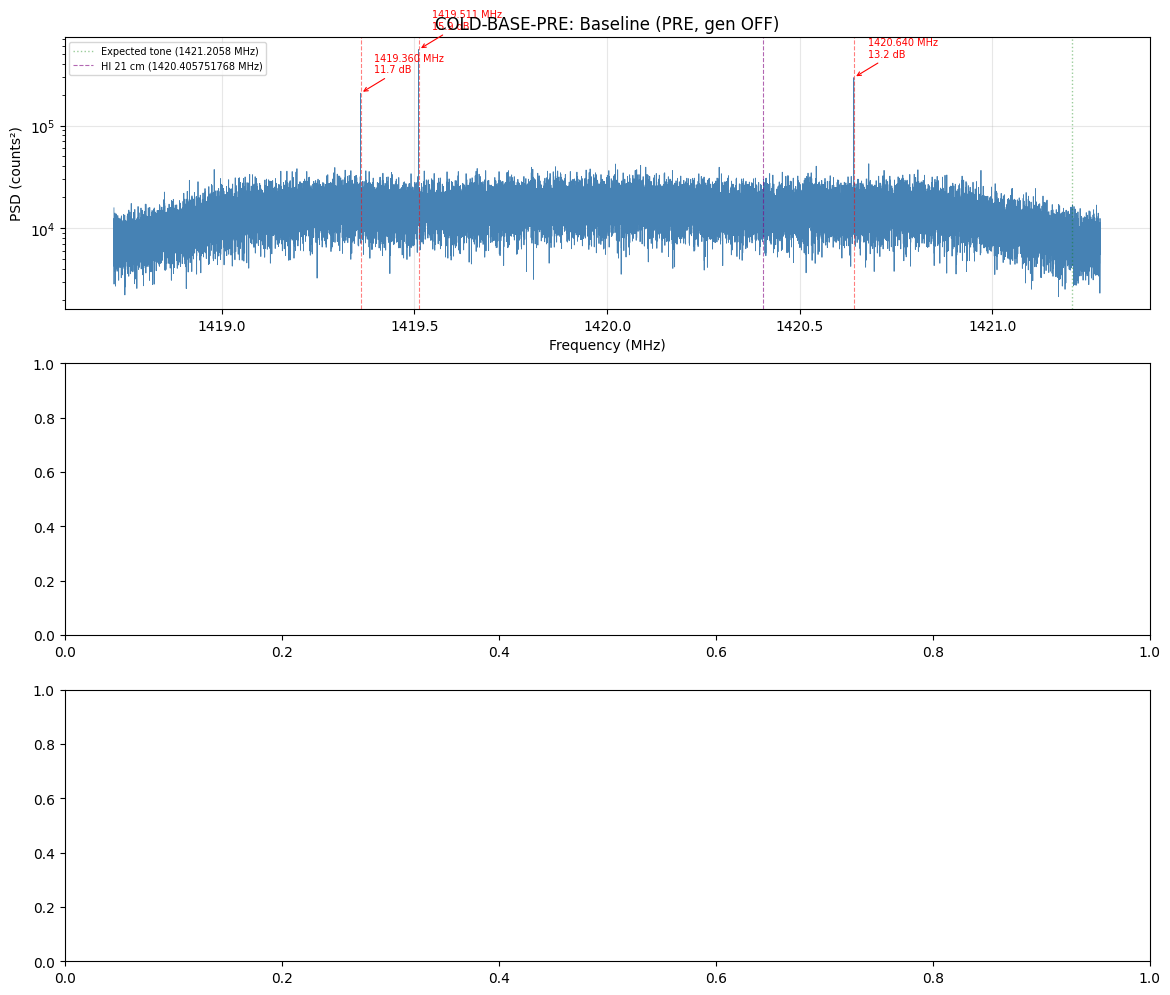

In [8]:
# Annotated peak identification on a few representative spectra
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

examples = [
    ('COLD-BASE-PRE', 'Baseline (PRE, gen OFF)'),
    ('COLD-TONE--40', 'Tone at -40 dBm (mid-range)'),
    ('COLD-TONE--30', 'Tone at -30 dBm (strongest)'),
]

tone_freq_mhz = 1421.2058

for ax, (key, title) in zip(axes, examples):
    row = df.loc[df['prefix'] == key].iloc[0]
    freqs = row['freqs_mhz']
    psd = row['psd']

    ax.semilogy(freqs, psd, lw=0.6, color='steelblue')

    # Mark detected peaks
    peaks = find_significant_peaks(freqs, psd, prominence_factor=3.0)
    for p in peaks:
        ax.axvline(p['freq_mhz'], color='red', alpha=0.5, lw=0.8, ls='--')
        ax.annotate(
            f"{p['freq_mhz']:.3f} MHz\n{p['snr_over_median_dB']:.1f} dB",
            xy=(p['freq_mhz'], p['psd']),
            xytext=(10, 15), textcoords='offset points',
            fontsize=7, color='red',
            arrowprops=dict(arrowstyle='->', color='red', lw=0.8),
        )

    # Mark expected tone location
    ax.axvline(tone_freq_mhz, color='green', alpha=0.4, lw=1, ls=':',
               label=f'Expected tone ({tone_freq_mhz} MHz)')
    # Mark HI 21-cm line
    ax.axvline(HI_FREQ, color='purple', alpha=0.6, lw=0.8, ls='--',
               label=f'HI 21 cm ({HI_FREQ} MHz)')

    ax.set_ylabel('PSD (counts²)')
    ax.set_xlabel('Frequency (MHz)')
    ax.set_title(f'{key}: {title}')
    ax.legend(loc='upper left', fontsize=7)
    ax.grid(True, alpha=0.3)

fig.suptitle('Peak Identification in Power Spectra', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# --- Step 3: Baseline subtraction ---
# For each dBm level, subtract the paired baseline PSD from the tone PSD
# to isolate the injected signal from system noise.

tone_freq_mhz = 1421.2058

sub_rows = []
for dbm in paired_dbm:
    tone_row = df.loc[df['prefix'] == f'COLD-TONE-{dbm}'].iloc[0]
    base_row = df.loc[df['prefix'] == f'COLD-BASE-{dbm}'].iloc[0]

    freqs = tone_row['freqs_mhz']
    diff_psd = tone_row['psd'] - base_row['psd']

    tone_bin = np.argmin(np.abs(freqs - tone_freq_mhz))

    sub_rows.append({
        'siggen_amp_dBm': dbm,
        'freqs_mhz': freqs,
        'diff_psd': diff_psd,
        'tone_bin_diff': diff_psd[tone_bin],
        'tone_bin_psd_cal': tone_row['psd'][tone_bin],
        'tone_bin_psd_base': base_row['psd'][tone_bin],
        'total_diff': np.sum(diff_psd),
        'mean_diff': np.mean(diff_psd),
    })

sub_df = pd.DataFrame(sub_rows)

# Summary table
print('Baseline-subtracted tone power at 1421.205 MHz:')
print(sub_df[['siggen_amp_dBm', 'tone_bin_psd_cal', 'tone_bin_psd_base',
              'tone_bin_diff', 'total_diff', 'mean_diff']].to_string(index=False))



In [ ]:
# Baseline-subtracted spectra (cal - obs) for each available dBm level
fig, axes = plt.subplots(len(sub_df), 1, figsize=(12, 4 * len(sub_df)))
axes = np.atleast_1d(axes)

for i, row in sub_df.iterrows():
    ax = axes[i]
    dbm = row['siggen_amp_dBm']
    freqs = row['freqs_mhz']
    diff = row['diff_psd']

    ax.plot(freqs, diff, lw=0.6, color='darkgreen')
    ax.axhline(0, color='gray', lw=0.5, ls='-')
    ax.axvline(tone_freq_mhz, color='green', alpha=0.4, lw=1, ls=':',
               label=f'Tone ({tone_freq_mhz} MHz)')
    ax.axvline(HI_FREQ, color='purple', alpha=0.6, lw=0.8, ls='--',
               label=f'HI 21 cm ({HI_FREQ} MHz)')
    ax.set_ylabel('ΔPSD (counts²)')
    ax.set_xlabel('Frequency (MHz)')
    ax.set_title(f'{int(dbm)} dBm: cal − baseline')
    ax.legend(loc='upper right', fontsize=7)
    ax.grid(True, alpha=0.3)

fig.suptitle('Baseline-Subtracted Power Spectra (tone ON − tone OFF)', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()



In [ ]:
# Baseline-subtracted statistics DataFrame
sub_stats = sub_df[['siggen_amp_dBm', 'tone_bin_diff', 'total_diff', 'mean_diff']].copy()
sub_stats['tone_diff_dB'] = 10 * np.log10(np.abs(sub_stats['tone_bin_diff']))
sub_stats['tone_diff_positive'] = sub_stats['tone_bin_diff'] > 0
sub_stats

In [ ]:
# --- Step 4: Linearity check ---
# Plot measured tone power vs input power (dBm).
# On a dB-vs-dB scale, a linear receiver should give slope ≈ 1.

from scipy.stats import linregress

# Use baseline-subtracted tone power at the tone bin
input_dbm = sub_df['siggen_amp_dBm'].values.astype(float)
tone_power = sub_df['tone_bin_diff'].values.astype(float)

# Also use total integrated power difference (more robust)
total_diff = sub_df['total_diff'].values.astype(float)

# Only fit where tone_bin_diff > 0 (tone is detectable above noise)
mask = tone_power > 0
input_fit = input_dbm[mask]
tone_power_fit = tone_power[mask]
tone_power_db = 10 * np.log10(tone_power_fit)

# Linear regression on dB vs dBm
slope, intercept, r_value, p_value, std_err = linregress(input_fit, tone_power_db)

print(f'Linearity fit (baseline-subtracted tone bin):')
print(f'  Points used: {mask.sum()} / {len(mask)} (where cal > base)')
print(f'  Slope:     {slope:.4f} dB/dBm  (ideal = 1.0)')
print(f'  Intercept: {intercept:.2f} dB')
print(f'  R²:        {r_value**2:.6f}')
print(f'  Std error: {std_err:.4f}')
print()

# Also fit total integrated power
mask_total = total_diff > 0
input_fit_t = input_dbm[mask_total]
total_db = 10 * np.log10(total_diff[mask_total])
slope_t, intercept_t, r_t, _, stderr_t = linregress(input_fit_t, total_db)

print(f'Linearity fit (total integrated power diff):')
print(f'  Points used: {mask_total.sum()} / {len(mask_total)}')
print(f'  Slope:     {slope_t:.4f} dB/dBm  (ideal = 1.0)')
print(f'  Intercept: {intercept_t:.2f} dB')
print(f'  R²:        {r_t**2:.6f}')

In [ ]:
# Linearity plot: measured output power (dB) vs input power (dBm)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- Left: tone bin power ---
# Plot all points, color by whether they were included in the fit
ax1.scatter(input_dbm[~mask], 10 * np.log10(np.abs(tone_power[~mask])),
            marker='x', color='gray', s=30, label='Excluded (cal ≤ base)', zorder=3)
ax1.scatter(input_fit, tone_power_db,
            marker='o', color='steelblue', s=30, label='Fit points', zorder=3)

# Fit line
x_line = np.linspace(input_fit.min(), input_fit.max(), 100)
ax1.plot(x_line, slope * x_line + intercept, 'r-', lw=1.5,
         label=f'Fit: slope={slope:.3f}, R²={r_value**2:.4f}')

# Ideal slope=1 reference
ax1.plot(x_line, 1.0 * x_line + intercept, 'k--', lw=0.8, alpha=0.5,
         label='Ideal slope=1')

ax1.set_xlabel('Input power (dBm)')
ax1.set_ylabel('Measured tone bin power (dB)')
ax1.set_title('Linearity: tone bin (baseline-subtracted)')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# --- Right: total integrated power ---
ax2.scatter(input_dbm[~mask_total], 10 * np.log10(np.abs(total_diff[~mask_total])),
            marker='x', color='gray', s=30, label='Excluded (total ≤ 0)', zorder=3)
ax2.scatter(input_fit_t, total_db,
            marker='o', color='darkorange', s=30, label='Fit points', zorder=3)

x_line_t = np.linspace(input_fit_t.min(), input_fit_t.max(), 100)
ax2.plot(x_line_t, slope_t * x_line_t + intercept_t, 'r-', lw=1.5,
         label=f'Fit: slope={slope_t:.3f}, R²={r_t**2:.4f}')
ax2.plot(x_line_t, 1.0 * x_line_t + intercept_t, 'k--', lw=0.8, alpha=0.5,
         label='Ideal slope=1')

ax2.set_xlabel('Input power (dBm)')
ax2.set_ylabel('Measured total ΔPSD (dB)')
ax2.set_title('Linearity: total integrated power (baseline-subtracted)')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

fig.suptitle('Receiver Linearity Check', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Residuals from ideal linearity
fig, ax = plt.subplots(figsize=(10, 5))

residual = tone_power_db - (slope * input_fit + intercept)
ideal_residual = tone_power_db - (1.0 * input_fit + intercept)

ax.stem(input_fit, residual, linefmt='steelblue', markerfmt='o', basefmt='gray',
        label=f'Residual from fit (slope={slope:.3f})')
ax.stem(input_fit, ideal_residual, linefmt='orange', markerfmt='s', basefmt='gray',
        label='Residual from ideal (slope=1)')
ax.axhline(0, color='gray', lw=0.5)
ax.set_xlabel('Input power (dBm)')
ax.set_ylabel('Residual (dB)')
ax.set_title('Linearity Residuals at Tone Bin')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# --- Step 5: Noise floor & system temperature ---
# Characterize the system noise from baseline-only captures.
# T_sys = P_noise / (k_B * B) where B = bandwidth per bin

k_B = 1.380649e-23  # Boltzmann constant (J/K)
sample_rate_hz = df['sample_rate'].iloc[0]
nsamples = 2048
bin_bw = sample_rate_hz / nsamples  # Hz per bin

# Collect noise statistics from all 23 baseline (obs) captures
obs_df = df[df['type'] == 'obs'].copy()

noise_rows = []
for _, row in obs_df.iterrows():
    psd = row['psd']
    iq = row['samples']

    # Exclude DC bin (center) and tone bin region for clean noise estimate
    freqs = row['freqs_mhz']
    dc_bin = np.argmin(np.abs(freqs - 1420.0))
    tone_bin = np.argmin(np.abs(freqs - tone_freq_mhz))

    # Mask: exclude ±5 bins around DC and tone
    mask = np.ones(len(psd), dtype=bool)
    mask[max(0, dc_bin-5):dc_bin+6] = False
    mask[max(0, tone_bin-5):tone_bin+6] = False

    clean_psd = psd[mask]

    # RMS voltage from time domain
    vrms = np.sqrt(np.mean(np.abs(iq)**2))

    noise_rows.append({
        'prefix': row['prefix'],
        'unix_time': row['unix_time'],
        'mean_psd': np.mean(clean_psd),
        'median_psd': np.median(clean_psd),
        'std_psd': np.std(clean_psd),
        'total_power': np.sum(psd),
        'vrms': vrms,
    })

noise_df = pd.DataFrame(noise_rows)

print('Baseline noise statistics (obs captures, excluding DC & tone bins):')
print(f'  Mean PSD across baselines:   {noise_df["mean_psd"].mean():.1f} counts²')
print(f'  Std of mean PSD:             {noise_df["mean_psd"].std():.1f} counts²')
print(f'  Mean Vrms:                   {noise_df["vrms"].mean():.2f} counts')
print(f'  Bin bandwidth:               {bin_bw:.1f} Hz')
print(f'  Total bandwidth:             {sample_rate_hz/1e6:.2f} MHz')
print()
noise_df

In [ ]:
# System temperature estimate using the calibration slope
# From step 4, we have: measured_dB = slope * input_dBm + intercept
# The noise floor in the same units lets us estimate T_sys.
#
# Method: use the linearity fit from total integrated power (more robust).
# At the noise floor (no tone), the total power is just system noise.
# P_noise (counts²) = mean baseline total_power
# P_tone (counts²) at known input → calibration factor counts²/Watt
# T_sys = P_noise / (cal_factor * k_B * B)

# Use a high-SNR cal point for calibration (e.g. -30 dBm)
cal_dbm = -30.0
cal_row = sub_df.loc[sub_df['siggen_amp_dBm'] == cal_dbm].iloc[0]
cal_power_watts = 10**((cal_dbm) / 10) * 1e-3  # dBm to Watts

# Baseline-subtracted total power at this level = counts² from the tone alone
cal_counts2 = cal_row['total_diff']

# Calibration factor: counts² per Watt
cal_factor = cal_counts2 / cal_power_watts

# Mean noise floor from baselines (total power)
mean_noise_counts2 = noise_df['total_power'].mean()

# Noise power in Watts
noise_watts = mean_noise_counts2 / cal_factor

# System temperature: P = k_B * T * B
T_sys = noise_watts / (k_B * sample_rate_hz)

print(f'Calibration reference: {cal_dbm} dBm = {cal_power_watts:.2e} W')
print(f'  Baseline-subtracted counts²: {cal_counts2:.3e}')
print(f'  Calibration factor: {cal_factor:.3e} counts²/W')
print()
print(f'Mean baseline noise:')
print(f'  Total PSD: {mean_noise_counts2:.3e} counts²')
print(f'  Equivalent power: {noise_watts:.3e} W')
print()
print(f'System temperature estimate:')
print(f'  T_sys = {T_sys:.0f} K')
print()
print('Note: This is a rough estimate. The ADC quantization, gain chain,')
print('and impedance matching all affect the absolute calibration.')

In [ ]:
# Noise floor visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: overlay all baseline spectra
ax = axes[0, 0]
for _, row in obs_df.iterrows():
    ax.semilogy(row['freqs_mhz'], row['psd'], lw=0.3, alpha=0.5)
ax.axvline(HI_FREQ, color='purple', alpha=0.6, lw=0.8, ls='--', label='HI 21 cm')
ax.axvline(1420.0, color='red', alpha=0.4, lw=0.8, ls=':', label='DC (1420 MHz)')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (counts²)')
ax.set_title(f'All {len(obs_df)} baseline spectra overlaid')
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)

# Top-right: mean ± std baseline spectrum
ax = axes[0, 1]
all_psd = np.array([row['psd'] for _, row in obs_df.iterrows()])
mean_psd = np.mean(all_psd, axis=0)
std_psd = np.std(all_psd, axis=0)
freqs = obs_df.iloc[0]['freqs_mhz']
ax.semilogy(freqs, mean_psd, lw=0.8, color='steelblue', label='Mean')
ax.fill_between(freqs, mean_psd - std_psd, mean_psd + std_psd,
                alpha=0.3, color='steelblue', label='±1σ')
ax.axvline(HI_FREQ, color='purple', alpha=0.6, lw=0.8, ls='--')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (counts²)')
ax.set_title('Mean baseline spectrum ± 1σ')
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)

# Bottom-left: noise Vrms over time
ax = axes[1, 0]
t_min = (noise_df['unix_time'] - noise_df['unix_time'].iloc[0]) / 60
ax.plot(t_min, noise_df['vrms'], 'o-', ms=4, color='steelblue')
ax.set_xlabel('Time since start (min)')
ax.set_ylabel('Vrms (counts)')
ax.set_title('Baseline Vrms over time')
ax.grid(True, alpha=0.3)

# Bottom-right: total power over time
ax = axes[1, 1]
ax.plot(t_min, noise_df['total_power'], 's-', ms=4, color='darkorange')
ax.set_xlabel('Time since start (min)')
ax.set_ylabel('Total PSD (counts²)')
ax.set_title('Baseline total power over time')
ax.grid(True, alpha=0.3)

fig.suptitle('Noise Floor Characterization (baseline captures only)', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# --- Step 6: Drift check ---
# Quantify how the baseline total power drifts over the observation window.

# Elapsed time for baseline captures
t0 = noise_df['unix_time'].iloc[0]
noise_df['elapsed_min'] = (noise_df['unix_time'] - t0) / 60.0

# Elapsed time for cal captures (join via prefix → df unix_time)
cal_df = df[df['type'] == 'cal'].copy()
cal_df['elapsed_min'] = (cal_df['unix_time'] - t0) / 60.0
# Merge cal timestamps into psd_stats
psd_stats['elapsed_min'] = cal_df['elapsed_min'].values

# Linear fit to baseline total power vs time
slope_drift, intercept_drift, r_drift, _, stderr_drift = linregress(
    noise_df['elapsed_min'], noise_df['total_power']
)

window_min = noise_df['elapsed_min'].iloc[-1] - noise_df['elapsed_min'].iloc[0]
total_drift = slope_drift * window_min
pct_drift = 100 * total_drift / noise_df['total_power'].mean()

print('Baseline drift analysis:')
print(f'  Observation window:  {window_min:.1f} min')
print(f'  Drift rate:          {slope_drift:.2e} counts²/min')
print(f'  Total drift:         {total_drift:.2e} counts² ({pct_drift:.2f}% of mean)')
print(f'  R²:                  {r_drift**2:.4f}')
print(f'  Std error of slope:  {stderr_drift:.2e} counts²/min')

In [ ]:
# Step 6 — Drift visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top: baseline total power vs elapsed time + linear fit
ax1.plot(noise_df['elapsed_min'], noise_df['total_power'], 'o-', ms=5,
         color='steelblue', label='Baseline total power')
x_fit = np.linspace(noise_df['elapsed_min'].min(), noise_df['elapsed_min'].max(), 100)
ax1.plot(x_fit, slope_drift * x_fit + intercept_drift, 'r--', lw=1.5,
         label=f'Fit: {slope_drift:.2e} counts²/min ({pct_drift:+.2f}% over window)')
ax1.set_ylabel('Total PSD (counts²)')
ax1.set_title('Baseline Drift Over Observation Window')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# Bottom: cal total power vs elapsed time, colored by dBm
sc = ax2.scatter(psd_stats['elapsed_min'], psd_stats['tone_total_psd'],
                 c=psd_stats['siggen_amp_dBm'], cmap='viridis', s=40, zorder=3)
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Signal gen (dBm)')
ax2.set_ylabel('Cal total PSD (counts²)')
ax2.set_xlabel('Elapsed time (min)')
ax2.set_title('Calibration Capture Total Power Over Time')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# --- Step 7: Build calibration curve ---
# Convert dBm → Watts, fit linear region, derive system temperature.

# Input power in Watts
sub_df['P_watts'] = 10**(sub_df['siggen_amp_dBm'] / 10) * 1e-3

# Identify linear region: total_diff must be well above the noise floor
noise_floor_std = noise_df['total_power'].std()
linear_mask = sub_df['total_diff'] > 3 * noise_floor_std

print(f'Noise floor std:       {noise_floor_std:.2e} counts²')
print(f'3σ threshold:          {3 * noise_floor_std:.2e} counts²')
print(f'Linear region points:  {linear_mask.sum()} / {len(sub_df)}')
print(f'Usable dBm range:      {sub_df.loc[linear_mask, "siggen_amp_dBm"].min():.0f} '
      f'to {sub_df.loc[linear_mask, "siggen_amp_dBm"].max():.0f} dBm')
print()

# Linear regression: Watts → counts² (total_diff)
P_lin = sub_df.loc[linear_mask, 'P_watts'].values
counts2_lin = sub_df.loc[linear_mask, 'total_diff'].values

slope_cal, intercept_cal, r_cal, _, stderr_cal = linregress(P_lin, counts2_lin)

print(f'Calibration fit (linear region):')
print(f'  Slope:               {slope_cal:.4e} counts²/W')
print(f'  Intercept:           {intercept_cal:.2e} counts²')
print(f'  R²:                  {r_cal**2:.6f}')
print(f'  Conversion factor:   {1/slope_cal:.4e} W/count²')
print()

# System temperature from calibration slope
mean_noise = noise_df['total_power'].mean()
T_sys_cal = mean_noise / (slope_cal * k_B * sample_rate_hz)

print(f'System temperature (from calibration curve):')
print(f'  Mean baseline power: {mean_noise:.3e} counts²')
print(f'  T_sys = {T_sys_cal:.0f} K')
print(f'  (Step 5 estimate:    {T_sys:.0f} K)')

In [ ]:
# Step 7 — Calibration curve visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# --- Top: linear scale (Watts vs counts²) ---
# All points
ax1.scatter(sub_df['P_watts'], sub_df['total_diff'], c='gray', s=30,
            label='All points', zorder=2)
# Linear region highlighted
ax1.scatter(sub_df.loc[linear_mask, 'P_watts'],
            sub_df.loc[linear_mask, 'total_diff'],
            c='steelblue', s=50, label='Linear region', zorder=3)

# Fit line over extended range
P_range = np.linspace(0, sub_df['P_watts'].max() * 1.1, 200)
ax1.plot(P_range, slope_cal * P_range + intercept_cal, 'r-', lw=1.5,
         label=f'Fit: slope={slope_cal:.2e} counts²/W, R²={r_cal**2:.4f}')

# Noise floor
ax1.axhline(3 * noise_floor_std, color='orange', ls='--', lw=1,
            label=f'3σ noise floor = {3*noise_floor_std:.2e}')
ax1.axhline(0, color='gray', lw=0.5)

ax1.set_xlabel('Input power (W)')
ax1.set_ylabel('Baseline-subtracted total PSD (counts²)')
ax1.set_title('Calibration Curve — Linear Scale')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# --- Bottom: log-log (dBm vs dB) showing full dynamic range ---
# Convert total_diff to dB (use abs for log, mark sign)
total_diff_all = sub_df['total_diff'].values
positive = total_diff_all > 0

# Plot positive values in dB
input_dbm_all = sub_df['siggen_amp_dBm'].values
ax2.scatter(input_dbm_all[positive],
            10 * np.log10(total_diff_all[positive]),
            c='steelblue', s=40, label='Positive ΔP', zorder=3)
ax2.scatter(input_dbm_all[~positive],
            10 * np.log10(np.abs(total_diff_all[~positive])),
            c='red', marker='x', s=40, label='Negative ΔP (|value|)', zorder=3)

# Extrapolated fit line across full dBm range
dbm_range = np.linspace(-55, -25, 200)
P_range_w = 10**(dbm_range / 10) * 1e-3
fit_counts2 = slope_cal * P_range_w + intercept_cal
fit_positive = fit_counts2 > 0
ax2.plot(dbm_range[fit_positive],
         10 * np.log10(fit_counts2[fit_positive]),
         'r--', lw=1.5, label='Extrapolated fit')

# Mark linear region bounds
dbm_min = sub_df.loc[linear_mask, 'siggen_amp_dBm'].min()
dbm_max = sub_df.loc[linear_mask, 'siggen_amp_dBm'].max()
ax2.axvspan(dbm_min, dbm_max, alpha=0.1, color='steelblue', label='Linear region')

# Noise floor in dB
ax2.axhline(10 * np.log10(3 * noise_floor_std), color='orange', ls='--', lw=1,
            label='3σ noise floor')

ax2.set_xlabel('Input power (dBm)')
ax2.set_ylabel('Baseline-subtracted total PSD (dB)')
ax2.set_title('Calibration Curve — Log Scale (Full Dynamic Range)')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()